# Telco Customer Churn Prediction – End-to-End Data Science Project

This notebook walks through an end-to-end churn prediction pipeline on the **Telco Customer Churn**** dataset.

We will:
1. Load and inspect the data
2. Clean and preprocess features
3. Perform Exploratory Data Analysis (EDA)
4. Engineer features
5. Build baseline and advanced models (Logistic Regression, XGBoost)
6. Tune hyperparameters
7. Evaluate and interpret models (metrics, curves, SHAP)
8. Save the trained models for future use


In [1]:
# ==========================
# Imports and Global Settings
# ==========================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import shap
import joblib
import warnings

warnings.filterwarnings("ignore")

# Set some plotting defaults
plt.style.use("default")
sns.set_theme()

In [2]:
# ==========================
# Load the Telco Churn Dataset
# ==========================

# Adjust the path if your file is somewhere else
data_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(data_path)

print("Data loaded successfully!")
print("Shape of dataset:", df.shape)

# Peek at first few rows
df.head()

Data loaded successfully!
Shape of dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# ==========================
# Basic Info and Target Overview
# ==========================

# Overall info: data types, non-null counts
print("=== Data Info ===")
df.info()

# Quick statistics for numerical columns
print("\n=== Numerical Summary ===")
display(df.describe())

# Check the target variable 'Churn'
print("\n=== Target Variable: Churn ===")
print(df['Churn'].value_counts())
print("\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True) * 100)

=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000



=== Target Variable: Churn ===
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [4]:
# ==========================
# Data Cleaning
# ==========================

# 1. Convert TotalCharges to numeric
# Some rows have blank strings, so we force errors='coerce' to get NaN for invalid entries
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Handle missing values in TotalCharges (very few rows)
missing_totalcharges = df['TotalCharges'].isna().sum()
print(f"Missing values in TotalCharges before imputation: {missing_totalcharges}")

# Use median imputation (robust to outliers)
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

missing_totalcharges_after = df['TotalCharges'].isna().sum()
print(f"Missing values in TotalCharges after imputation: {missing_totalcharges_after}")

# 3. Drop customerID - purely an identifier, no predictive value
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)
    print("\nColumn 'customerID' dropped.")

print("\nShape after cleaning:", df.shape)

Missing values in TotalCharges before imputation: 11
Missing values in TotalCharges after imputation: 0

Column 'customerID' dropped.

Shape after cleaning: (7043, 20)


In [5]:
# ==========================
# Encode Target Variable and Check Class Imbalance
# ==========================

# Churn is currently 'Yes'/'No', convert to 1/0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("Unique values in Churn after encoding:", df['Churn'].unique())

# Class distribution
churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print("\nChurn counts:")
print(churn_counts)
print("\nChurn percentage:")
print(churn_pct)

Unique values in Churn after encoding: [0 1]

Churn counts:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn percentage:
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


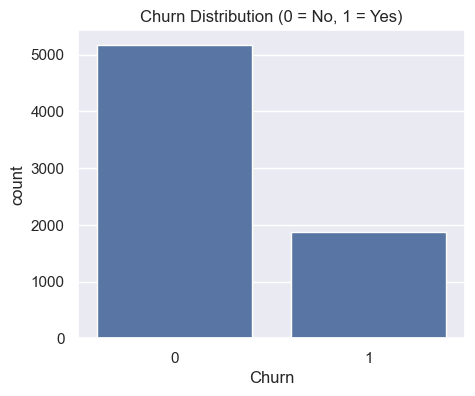

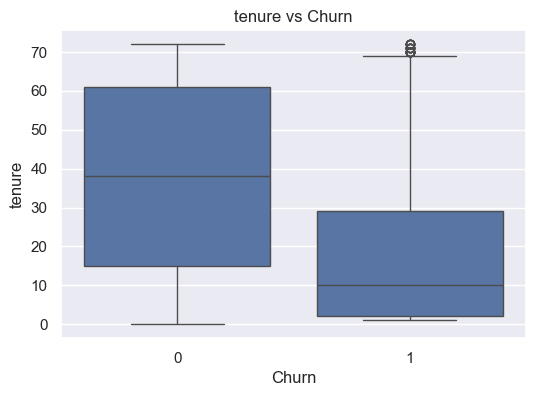

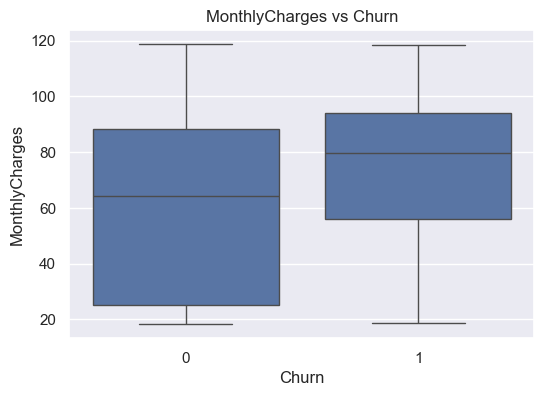

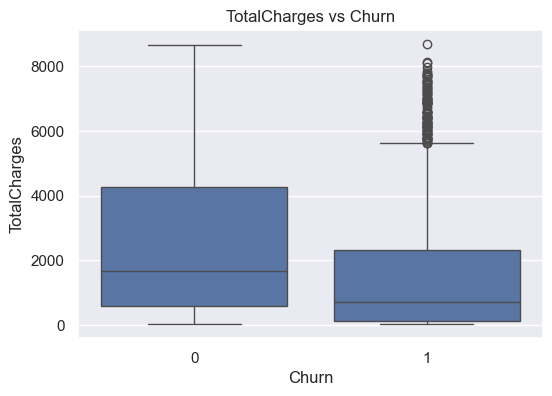

In [6]:
# ==========================
# EDA: Churn Distribution & Numeric Features
# ==========================

# 1. Churn distribution plot
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution (0 = No, 1 = Yes)')
plt.show()

# 2. Boxplots for numeric columns vs churn
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} vs Churn')
    plt.show()

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


<Figure size 600x400 with 0 Axes>

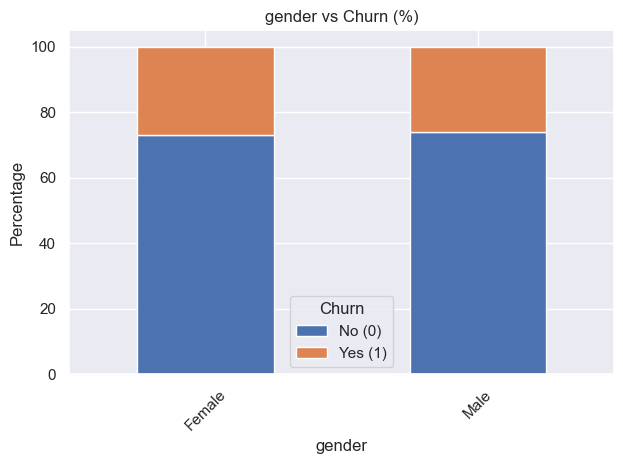

<Figure size 600x400 with 0 Axes>

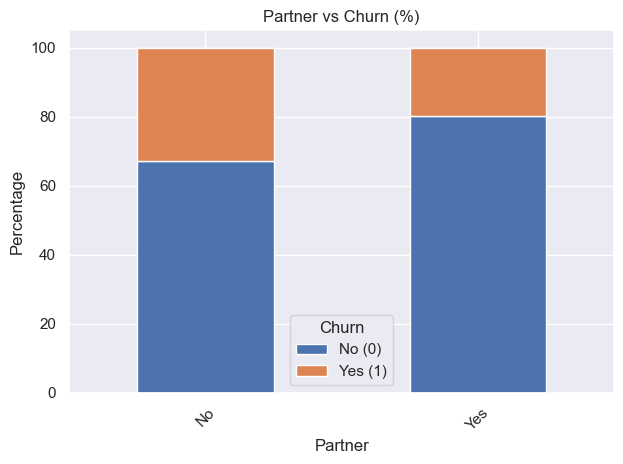

<Figure size 600x400 with 0 Axes>

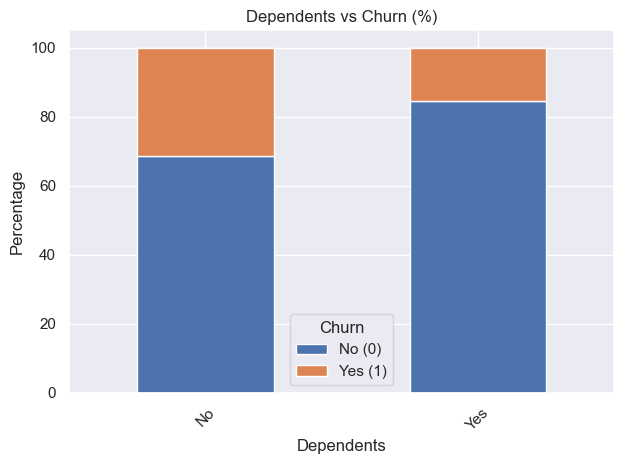

<Figure size 600x400 with 0 Axes>

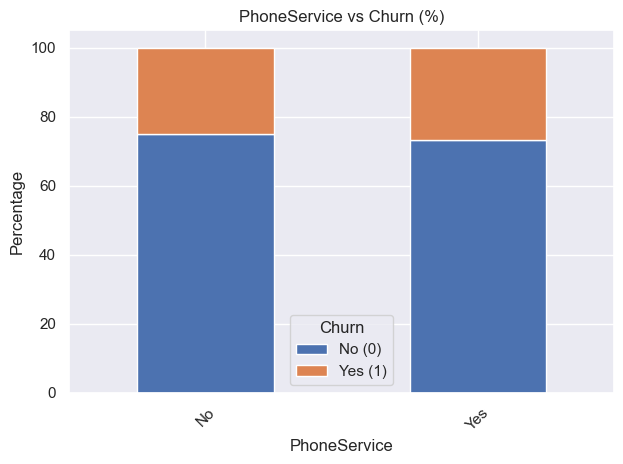

<Figure size 600x400 with 0 Axes>

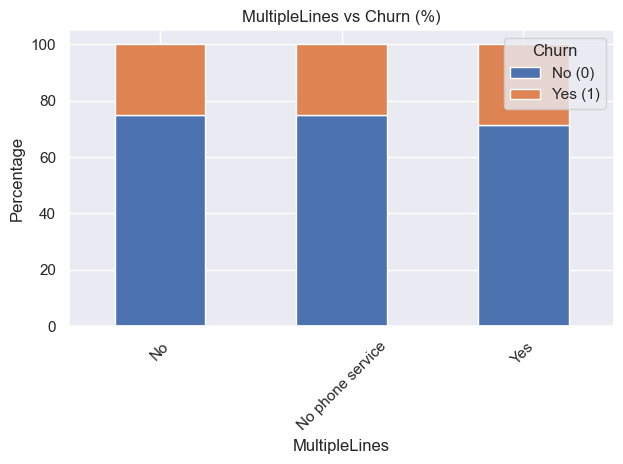

<Figure size 600x400 with 0 Axes>

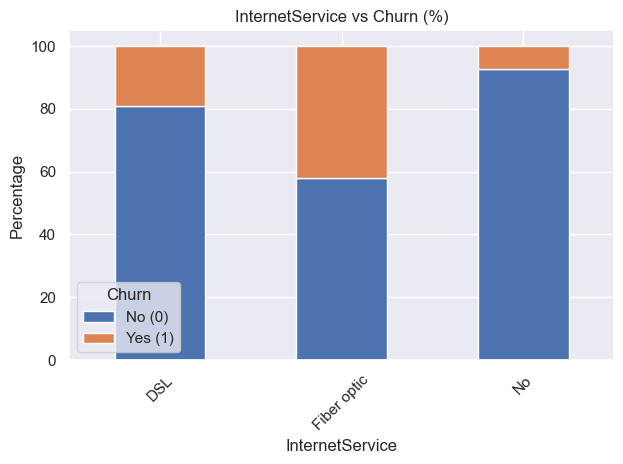

<Figure size 600x400 with 0 Axes>

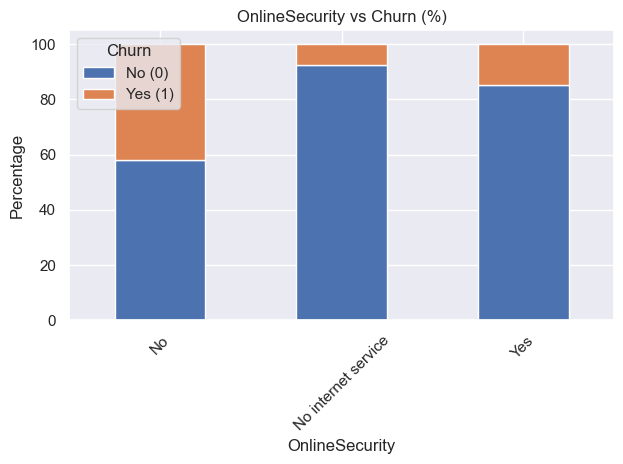

<Figure size 600x400 with 0 Axes>

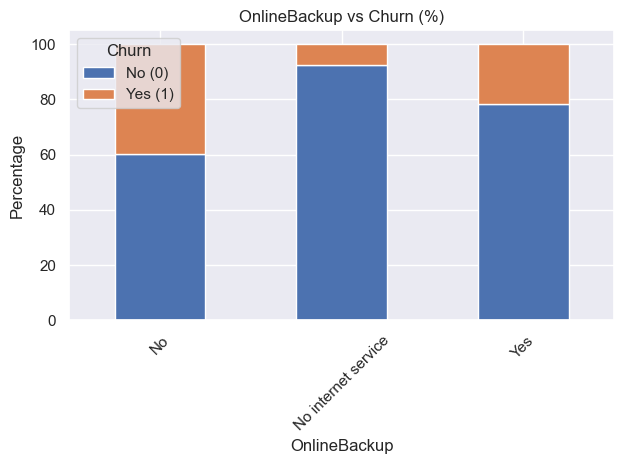

<Figure size 600x400 with 0 Axes>

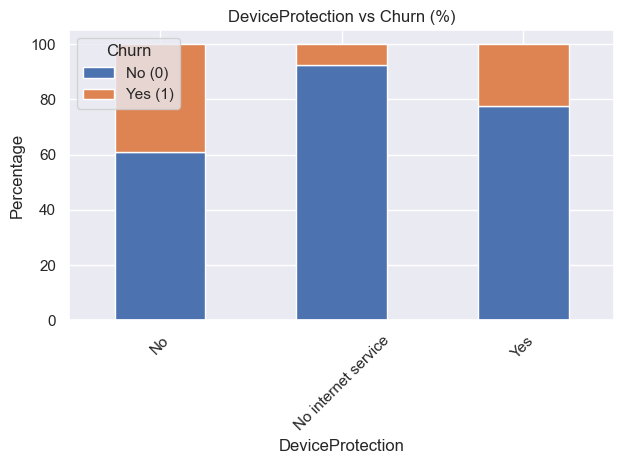

<Figure size 600x400 with 0 Axes>

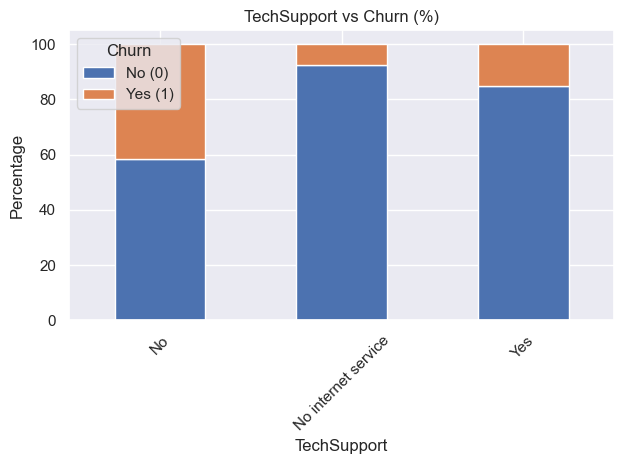

<Figure size 600x400 with 0 Axes>

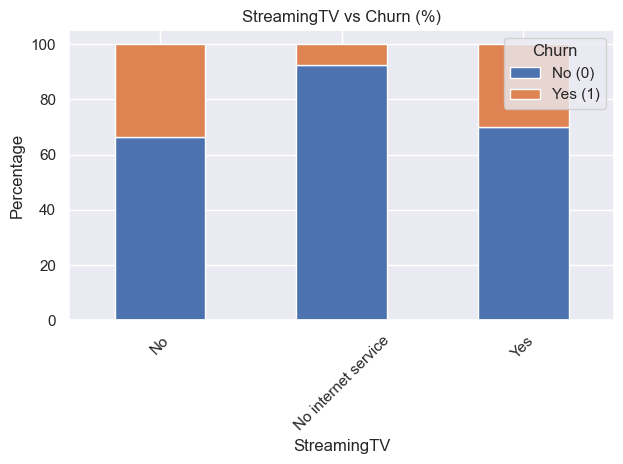

<Figure size 600x400 with 0 Axes>

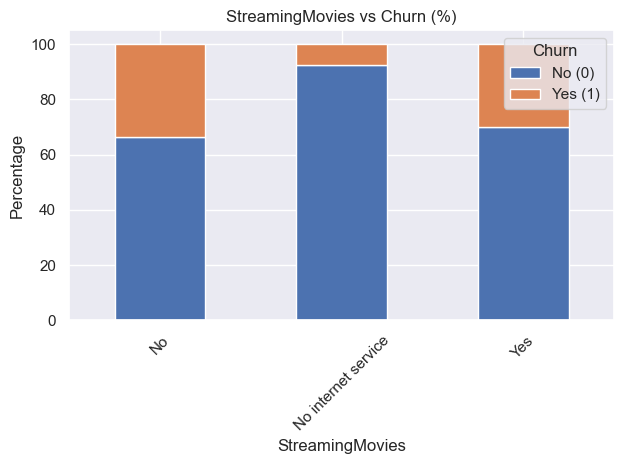

<Figure size 600x400 with 0 Axes>

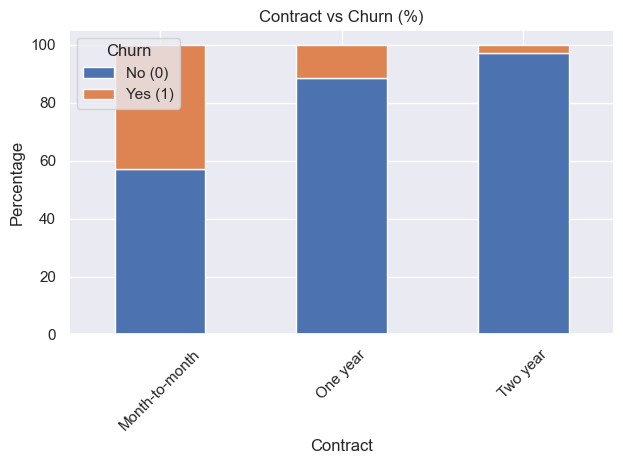

<Figure size 600x400 with 0 Axes>

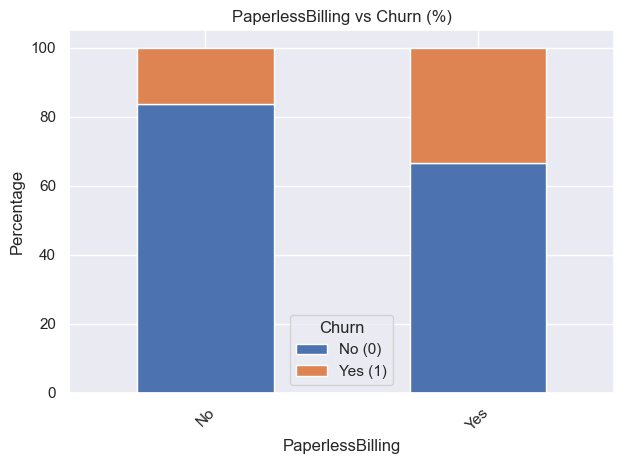

<Figure size 600x400 with 0 Axes>

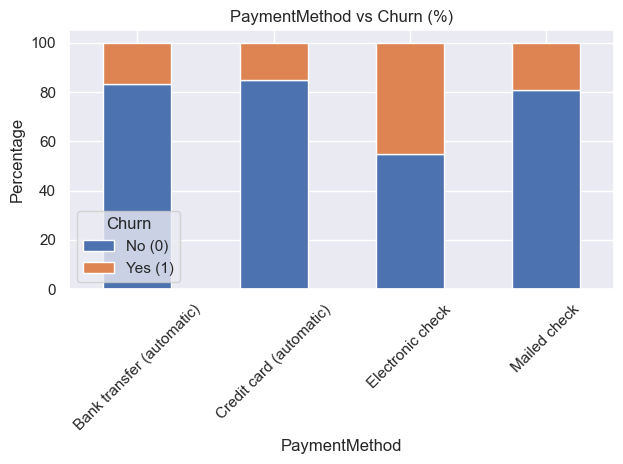

In [7]:
# ==========================
# EDA: Categorical Features vs Churn
# ==========================

# Select categorical columns (object type)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Categorical columns:", cat_cols)

for col in cat_cols:
    plt.figure(figsize=(6,4))
    # Cross-tab normalized by row (feature value)
    churn_rate = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    churn_rate.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Churn (%)')
    plt.ylabel('Percentage')
    plt.legend(title='Churn', labels=['No (0)', 'Yes (1)'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
# ==========================
# Feature Engineering
# ==========================

# Example engineered feature:
# Average charge per month = TotalCharges / tenure
# To avoid division by zero, replace tenure 0 with 1 temporarily
df['AvgChargePerMonth'] = df['TotalCharges'] / df['tenure'].replace(0, 1)

print("New feature 'AvgChargePerMonth' created.")

# Quick check of new feature
df[['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargePerMonth']].head()

New feature 'AvgChargePerMonth' created.


,tenure,MonthlyCharges,TotalCharges,AvgChargePerMonth
0,1,29.85,29.85,29.850000
1,34,56.95,1889.50,55.573529
2,2,53.85,108.15,54.075000
3,45,42.30,1840.75,40.905556
4,2,70.70,151.65,75.825000


In [9]:
# ==========================
# One-Hot Encode Categorical Variables & Train-Test Split
# ==========================

# One-hot encode all remaining categorical columns
df_encoded = pd.get_dummies(df, drop_first=True)

print("Shape before encoding:", df.shape)
print("Shape after encoding:", df_encoded.shape)

# Split features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Stratified split to maintain class balance in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Shape before encoding: (7043, 21)
Shape after encoding: (7043, 32)
Train shape: (5634, 31)
Test shape : (1409, 31)


In [10]:
# ==========================
# Feature Scaling for Numeric Features
# ==========================

# List of numeric features we want to scale
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargePerMonth']

scaler = StandardScaler()

# Fit on train, transform train and test
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

print("Scaling applied to numeric features:", num_features)

Scaling applied to numeric features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargePerMonth']


In [11]:
# ==========================
# Helper Function: Model Evaluation
# ==========================

def evaluate_model(y_true, y_pred, y_proba, model_name="Model"):
    """
    Prints classification metrics, shows confusion matrix,
    ROC curve, and Precision-Recall curve for a given model.
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    
    print(f"\n====== {model_name} Performance ======")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.show()
    
    # Precision-Recall Curve
    precisions, recalls, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.show()


====== Logistic Regression Performance ======
Accuracy : 0.7402
Precision: 0.5069
Recall   : 0.7861
F1-score : 0.6164
ROC-AUC  : 0.8421

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



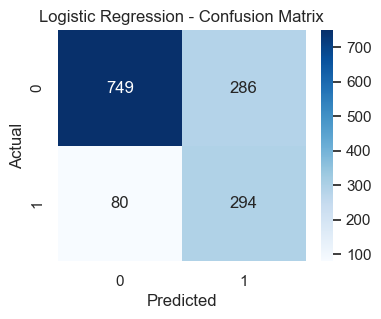

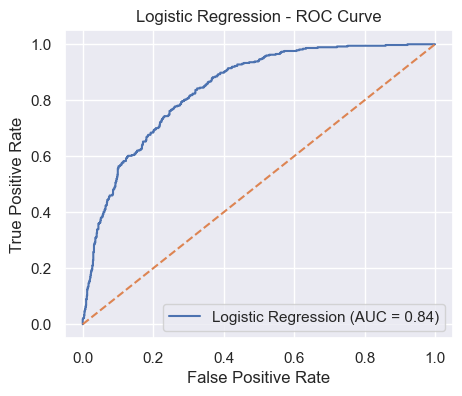

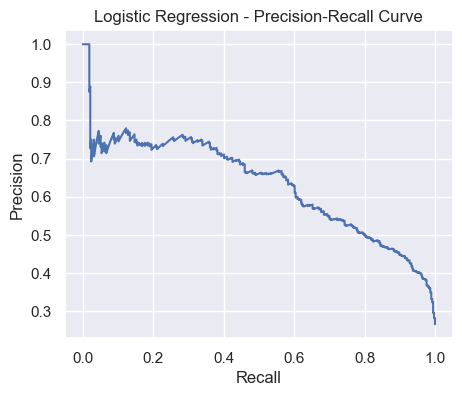

In [12]:
# ==========================
# Model 1: Logistic Regression (Baseline)
# ==========================

# We use class_weight='balanced' to handle churn imbalance
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)

lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

# Evaluate
evaluate_model(y_test, y_pred_lr, y_proba_lr, model_name="Logistic Regression")


====== XGBoost (Base) Performance ======
Accuracy : 0.7757
Precision: 0.5918
Recall   : 0.5000
F1-score : 0.5420
ROC-AUC  : 0.8201

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.59      0.50      0.54       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



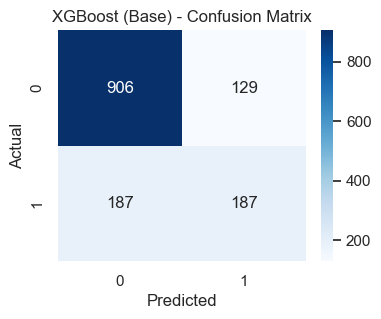

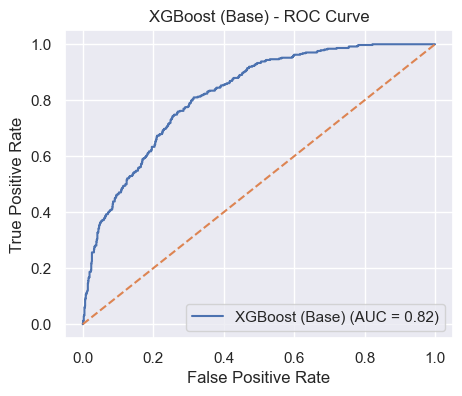

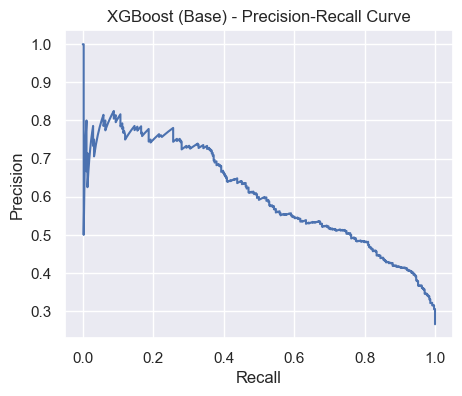

In [13]:
# ==========================
# Model 2: XGBoost (Base Model)
# ==========================

xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

xgb_base.fit(X_train, y_train)

y_pred_xgb_base = xgb_base.predict(X_test)
y_proba_xgb_base = xgb_base.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred_xgb_base, y_proba_xgb_base, model_name="XGBoost (Base)")

In [14]:
# ==========================
# Hyperparameter Tuning: XGBoost with RandomizedSearchCV
# ==========================

# Parameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False,
    n_jobs=-1
)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=25,              # number of random combos to try
    scoring='roc_auc',
    n_jobs=-1,
    cv=skf,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters found:", random_search.best_params_)
print("Best CV ROC-AUC:", random_search.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters found: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best CV ROC-AUC: 0.8484533075915667



====== XGBoost (Tuned) Performance ======
Accuracy : 0.7991
Precision: 0.6904
Recall   : 0.4412
F1-score : 0.5383
ROC-AUC  : 0.8481

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1035
           1       0.69      0.44      0.54       374

    accuracy                           0.80      1409
   macro avg       0.76      0.68      0.70      1409
weighted avg       0.79      0.80      0.78      1409



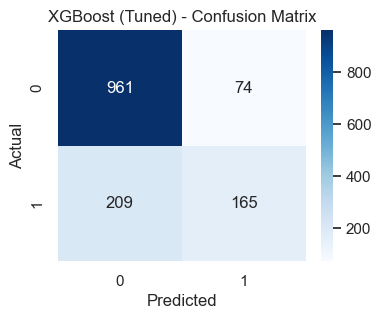

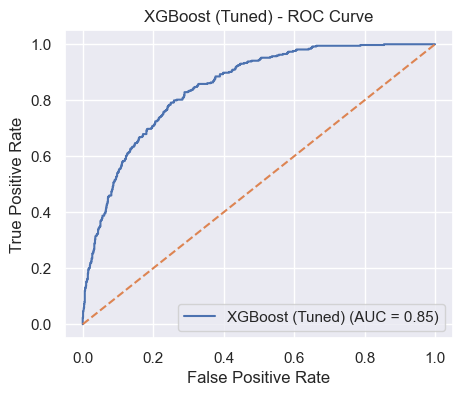

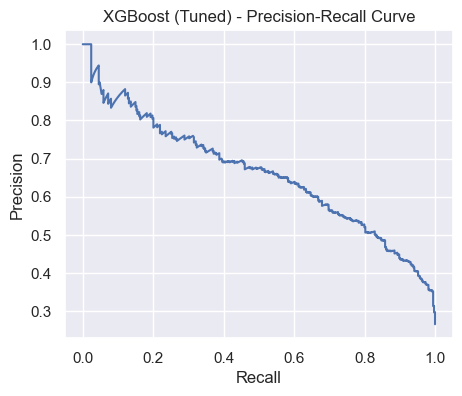

In [15]:
# ==========================
# Evaluate Tuned XGBoost Model
# ==========================

best_xgb = random_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred_xgb, y_proba_xgb, model_name="XGBoost (Tuned)")

Best threshold (for F1): 0.2879
Best F1-score at that threshold: 0.6372

====== XGBoost (Tuned + Threshold=0.29) Performance ======
Accuracy : 0.7608
Precision: 0.5333
Recall   : 0.7914
F1-score : 0.6372
ROC-AUC  : 0.8481

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1035
           1       0.53      0.79      0.64       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.77      1409



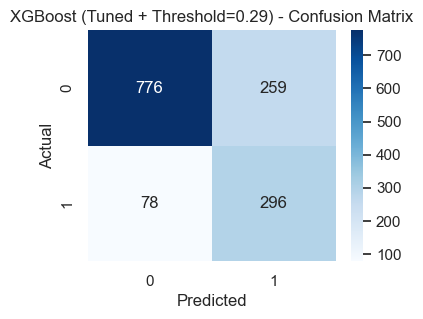

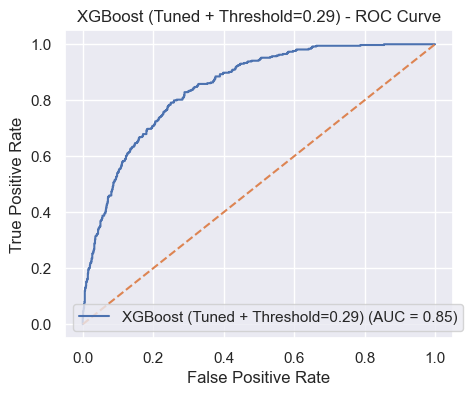

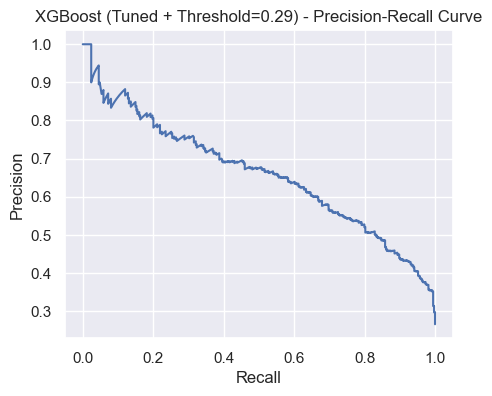

In [16]:
# ==========================
# Threshold Tuning (Optimize F1) for XGBoost
# ==========================

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_xgb)

# Compute F1 for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold (for F1): {best_threshold:.4f}")
print(f"Best F1-score at that threshold: {f1_scores[best_idx]:.4f}")

# Apply custom threshold
y_pred_xgb_custom = (y_proba_xgb >= best_threshold).astype(int)

evaluate_model(
    y_test,
    y_pred_xgb_custom,
    y_proba_xgb,
    model_name=f"XGBoost (Tuned + Threshold={best_threshold:.2f})"
)

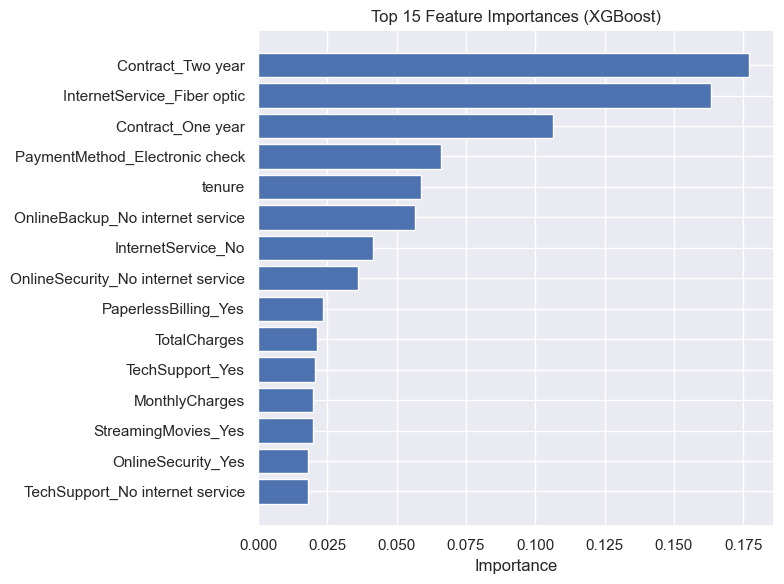

In [17]:
# ==========================
# Feature Importance from Tuned XGBoost
# ==========================

importances = best_xgb.feature_importances_
indices = np.argsort(importances)[-15:]  # indices of top 15 features

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

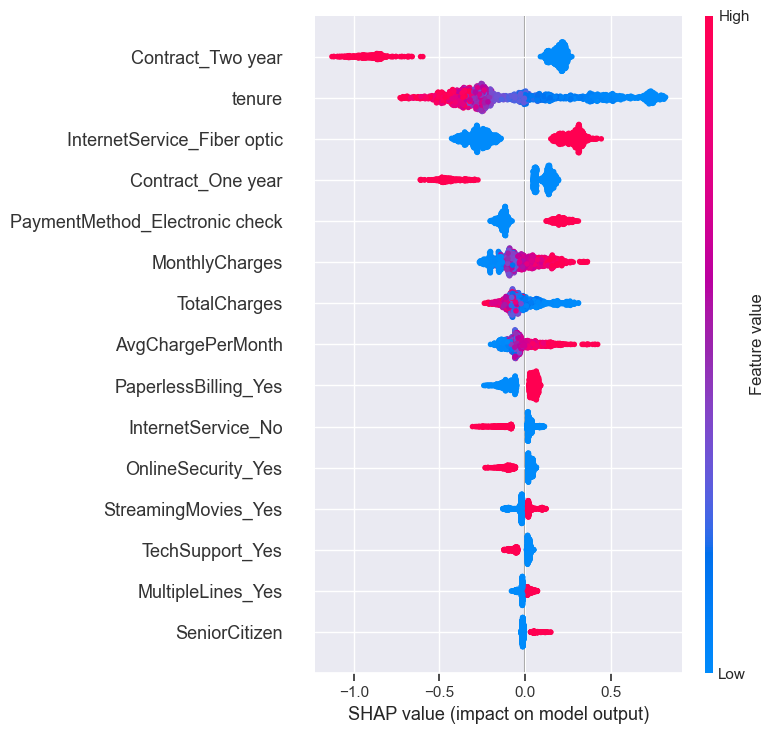

In [18]:
# ==========================
# SHAP Explainability for Tuned XGBoost
# ==========================

# SHAP can be slow on very large datasets; here it's manageable
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Global explanation: which features are most important and how they affect churn
shap.summary_plot(shap_values, X_test, max_display=15)

In [19]:
# ==========================
# Save Trained Models and Scaler
# ==========================

import os

os.makedirs("models", exist_ok=True)

joblib.dump(lr, "models/logistic_regression.pkl")
joblib.dump(best_xgb, "models/xgboost_tuned.pkl")
joblib.dump(scaler, "models/scaler.pkl")

print("Models and scaler saved in 'models/' directory.")

Models and scaler saved in 'models/' directory.


In [20]:
# ==========================
# Save Feature Columns for Deployment
# ==========================

import os
os.makedirs("models", exist_ok=True)

# Save the columns order used during training
feature_columns = X_train.columns.tolist()

joblib.dump(feature_columns, "models/feature_columns.pkl")

print("Saved feature columns to models/feature_columns.pkl")
print("Number of features:", len(feature_columns))

Saved feature columns to models/feature_columns.pkl
Number of features: 31
